# Credit Card Fraud

Presentation of the dataset is available on <a href="https://www.kaggle.com/dalpozz/creditcardfraud" target="_blank"> Kaggle </a>

The datasets contains transactions made by credit cards in September 2013 by european cardholders. This dataset presents transactions that occurred in two days, where we have 492 frauds out of 284,807 transactions. The dataset is highly unbalanced, the positive class (frauds) account for 0.172% of all transactions.

It contains only numerical input variables which are the result of a PCA transformation. Unfortunately, due to confidentiality issues, we cannot provide the original features and more background information about the data. Features V1, V2, ... V28 are the principal components obtained with PCA, the only features which have not been transformed with PCA are 'Time' and 'Amount'. Feature 'Time' contains the seconds elapsed between each transaction and the first transaction in the dataset. The feature 'Amount' is the transaction Amount, this feature can be used for example-dependant cost-senstive learning. Feature 'Class' is the response variable and it takes value 1 in case of fraud and 0 otherwise.

Given the class imbalance ratio, we recommend measuring the accuracy using the Area Under the Precision-Recall Curve (AUPRC). Confusion matrix accuracy is not meaningful for unbalanced classification.

The dataset has been collected and analysed during a research collaboration of Worldline and the Machine Learning Group (http://mlg.ulb.ac.be) of ULB (Université Libre de Bruxelles) on big data mining and fraud detection. More details on current and past projects on related topics are available on http://mlg.ulb.ac.be/BruFence and http://mlg.ulb.ac.be/ARTML

<i>Source: Andrea Dal Pozzolo, Olivier Caelen, Reid A. Johnson and Gianluca Bontempi. Calibrating Probability with Undersampling for Unbalanced Classification. In Symposium on Computational Intelligence and Data Mining (CIDM), IEEE, 2015</i>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA, IncrementalPCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import recall_score, confusion_matrix, precision_score, accuracy_score
from sklearn.linear_model import SGDClassifier
from sklearn.base import clone
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier


%matplotlib inline

# Dataset Exploration

First let's explore quickly the dataset. I won't explain all what we have as it is described on above

In [2]:
dataset = pd.read_csv("creditcard.csv")

In [3]:
print(dataset.head())
print(dataset.describe())
print(dataset.info())

   Time        V1        V2        V3        V4        V5        V6        V7  \
0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2   1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3   1.0 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4   2.0 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9  ...         V21       V22       V23       V24  \
0  0.098698  0.363787  ...   -0.018307  0.277838 -0.110474  0.066928   
1  0.085102 -0.255425  ...   -0.225775 -0.638672  0.101288 -0.339846   
2  0.247676 -1.514654  ...    0.247998  0.771679  0.909412 -0.689281   
3  0.377436 -1.387024  ...   -0.108300  0.005274 -0.190321 -1.175575   
4 -0.270533  0.817739  ...   -0.009431  0.798278 -0.137458  0.141267   

        V25       V26       V27       V28  Amount  Class  
0  0.128539 -0.189115

In [4]:
dataset['Class'].value_counts()

0    284315
1       492
Name: Class, dtype: int64

Let's now explore the repartition of the amount of each transactions

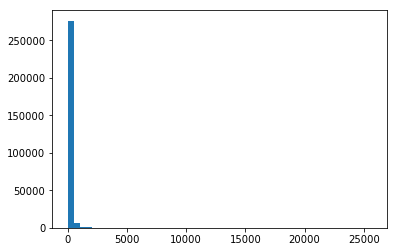

In [5]:
plt.hist(dataset['Amount'], bins=50)
plt.show()

As we can imagine mainly all transaction are below 1500 \$. In order to reduce the range of amount we can check how many frauds we have above 3000 \$

In [6]:
dataset[(dataset['Amount'] > 3000) & (dataset['Class']==1)]

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class


Good point, there is none so we can remove transaction with an amoutn above 3000 \$. After we can check the repartition of frauds based on the amount and the cost for the bank as Warranty

In [7]:
dataset = dataset[dataset['Amount'] < 3000]

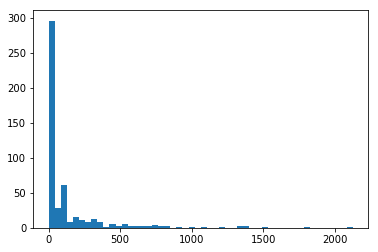

In [8]:
fraud = dataset[dataset['Class']==1]
plt.hist(fraud['Amount'], bins=50)
plt.show()

0 => 2073.9300000000007 $ - 2073.9300000000007
50 => 4945.329999999998 $ - 7019.259999999998
100 => 3646.77 $ - 10666.029999999999
150 => 2496.0499999999997 $ - 13162.079999999998
200 => 2519.32 $ - 15681.399999999998
250 => 2983.95 $ - 18665.35
300 => 4872.54 $ - 23537.89
350 => 2189.02 $ - 25726.91
400 => 870.5699999999999 $ - 26597.48
450 => 2335.59 $ - 28933.07
500 => 2622.46 $ - 31555.53
550 => 1164.38 $ - 32719.91
600 => 2518.13 $ - 35238.04
650 => 667.55 $ - 35905.590000000004
700 => 5063.5199999999995 $ - 40969.11
750 => 1543.19 $ - 42512.3
800 => 2456.7599999999998 $ - 44969.060000000005
850 => 0 $ - 44969.060000000005
900 => 925.31 $ - 45894.37
950 => 996.27 $ - 46890.64
1000 => 0 $ - 46890.64
1050 => 1096.99 $ - 47987.63
1100 => 0 $ - 47987.63
1150 => 0 $ - 47987.63
1200 => 1218.89 $ - 49206.52
1250 => 0 $ - 49206.52
1300 => 1335.0 $ - 50541.52
1350 => 2743.81 $ - 53285.329999999994
1400 => 1402.16 $ - 54687.49
1450 => 0 $ - 54687.49
1500 => 1504.93 $ - 56192.42
1550 => 0 $ 

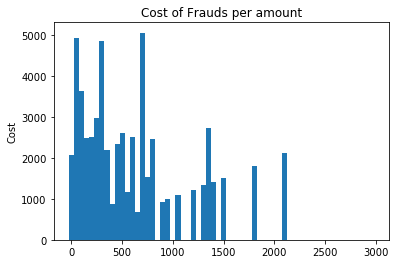

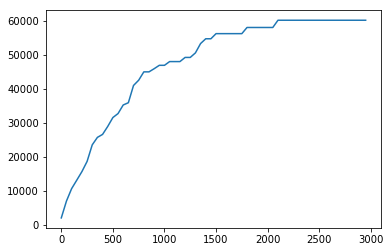

In [9]:
bins = 50
Amount_max = 3000

Y = []
C = []
X = list(range(0, Amount_max, bins))
for i in X:
    s = fraud[(fraud['Amount'] > i) & (fraud['Amount'] <= i + bins)]['Amount'].sum()
    Y.append(s)
    if len(C) > 0:
        c = C[-1] + s
    else:
        c = s
    C.append(c)
    print("{} => {} $ - {}".format(i, s, c))

plt.bar(X, Y, width=50)
plt.ylabel('Cost')
plt.title('Cost of Frauds per amount')
plt.show()

plt.plot(X, C)
plt.show()

So we can see that most of frauds are below 500 \$. Nevertheless in term of cost, all fraud below 500 \$ cost 31500 \$ to the bank (50% of the total cost of frauds). If we want to avoid around 90% of fraud costs, we should consider frauds up to 1500 \$. In the first time we will try to catch a maximum a fraud and depending on the result we may focus only on frauds < 1500 \$

# Model simplification

We clearly have a unbalanced dataset as we have only 0.17% of frauds. One good thing to do in such case is to try some <a href="https://en.wikipedia.org/wiki/Oversampling_and_undersampling_in_data_analysis" target="_blank">Random Undersampling</a>

<b>For now, we only explore the dataset, the dataset will be splitted for evaluation later</b>

In [10]:
random_seed = 42
n_non_fraud = [100, 1000, 10000, 100000, dataset[dataset["Class"] == 0]["Class"].count()]         # min : 1 - max : 284807-492
n_components = 3
print(n_non_fraud)

[100, 1000, 10000, 100000, 284026]


C:\Anaconda\lib\site-packages\matplotlib\collections.py:877: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


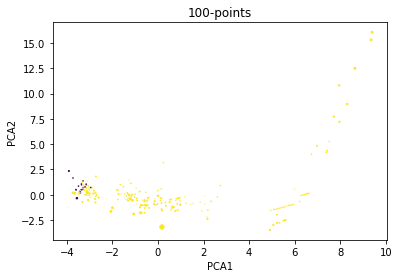

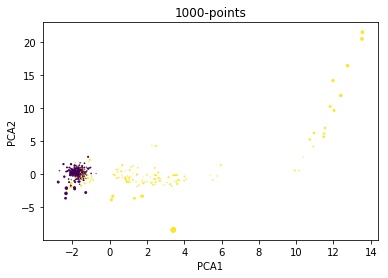

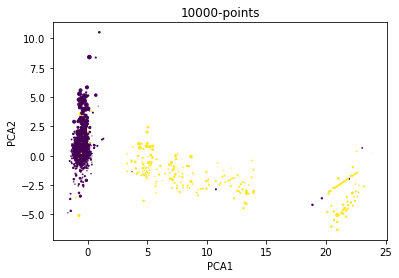

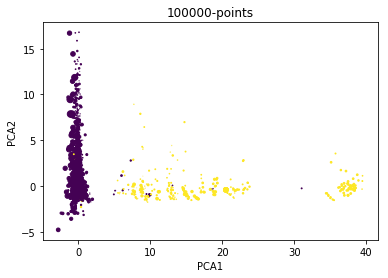

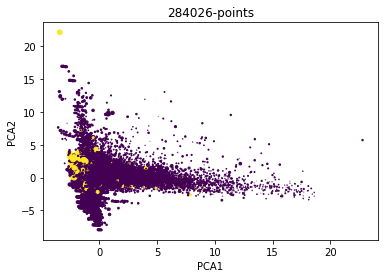

In [11]:
for sample_size in n_non_fraud:
    a = dataset[dataset["Class"] == 1]                                                # we keep all frauds
    b = dataset[dataset["Class"] == 0].sample(sample_size, random_state=random_seed)  # we take "sample_size" non fraud to balance the ratio fraud/non_fraud

    dataset_us = pd.concat([a, b]).sample(frac=1, random_state=random_seed)           # merge and shuffle both dataset
    
    y = dataset_us["Class"]
    X = dataset_us.drop(["Time", "Class"], axis=1)
    
    X_scale = StandardScaler().fit_transform(X)
    X_proj = PCA(n_components=n_components).fit_transform(X_scale)
    
    plt.scatter(X_proj[:, 0], X_proj[:, 1], s=X_proj[:, 2], c=y)

    plt.xlabel("PCA1")
    plt.ylabel("PCA2")
    plt.title("{}-points".format(sample_size))
    #plt.savefig("{}-points".format(sample_size), dpi=600)
    plt.show()

With 100 and 1000 non-frauds, we can see that non fraud are packed but some fraud are also grouped. With 10k and there is still some yellow points included in violet ones. With the full dataset, the reduction is useless as we packed all points.

Nevertheless, with 100000 points, we have a nice split in 2 dimensions. We can fix this value to fit the PCA and use it in the full datraset afterward.

In [12]:
# fit the PCA with 100k non-frauds
a = dataset[dataset["Class"] == 1]
b = dataset[dataset["Class"] == 0].sample(100000, random_state=random_seed)

dataset = pd.concat([a, b]).sample(frac=1, random_state=random_seed)

y = dataset["Class"]
X = dataset.drop(["Time", "Class"], axis=1)

X_scale = StandardScaler().fit_transform(dataset)
pca = PCA(n_components=0.95, svd_solver="full")
X_proj = pca.fit(X_scale)

# transform the full dataset with the pca create previously
dataset = pd.read_csv("creditcard.csv")
y = dataset["Class"]
X = dataset.drop(["Time", "Class"], axis=1)

X_scale = StandardScaler().fit_transform(dataset)
X_proj = pca.transform(X_scale)

# Setting up a model

Above instead of keeping only the 3 main dimensions, we reduce dimensions until having 5% loss. We can check how many features we have :

In [13]:
print(X_proj.shape)

(284807, 27)


Unfortunately, we drop only 2 additionnal dimensions but it's better than nothing. We can check also that our reduction still allow a nice split.

C:\Anaconda\lib\site-packages\matplotlib\collections.py:877: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


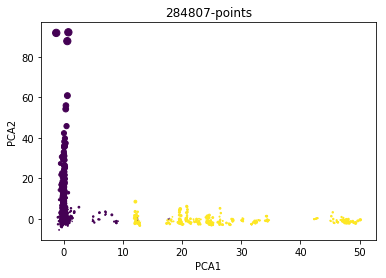

In [14]:
plt.scatter(X_proj[:, 0], X_proj[:, 1], s=X_proj[:, 2], c=y)

plt.xlabel("PCA1")
plt.ylabel("PCA2")
plt.title("{}-points".format(X_proj.shape[0]))
#plt.savefig("{}-points".format(sample_size), dpi=600)
plt.show()

For this model, it would be bad to use a standard split as we have an unbalanced dataset (492 frauds for 280k non-frauds). In such case we should definitely go for a StratifiedKFold with let say 5 folds to have around 100 frauds in each fold.

For now we gonna try some classification model and our target won't be the count of good guess. In this exercice it makes no sense as we can easily reach 99.8% as we only have 0.17% fraud in total. A classifier saying non fraud everytime would get 99.8%.

Instead our score will be the number of non detected frauds (False Negative). So we must maximise the <b>Precision</b>

Just as reminder, confusion matrix is :

\begin{vmatrix}
Non\_Fraud\_detected\_as\_non\_fraud &  Fraud\_detected\_as\_non\_fraud \\
Non\_Fraud\_detected\_as\_Fraud &  Fraud\_detected\_as\_Fraud
\end{vmatrix}

In [15]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_seed)  #shuffle is required to avoid having unbalance folds
sgd_clf = SGDClassifier(random_state=random_seed)
for train_index, test_index in skf.split(X_proj, y):
    clone_clf = clone(sgd_clf)
    X_train, X_test = X_proj[train_index], X_proj[test_index]
    y_train, y_test = y[train_index], y[test_index]
    clone_clf.fit(X_train, y_train)
    y_pred = clone_clf.predict(X_test)
    recall = recall_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    print("\nRecall:\t\t {:.4f} \nPrecision:\t {:.4f}".format(recall, precision))
    print(confusion_matrix(y_test, y_pred))


Recall:		 0.8990 
Precision:	 0.9674
[[56860     3]
 [   10    89]]

Recall:		 0.8889 
Precision:	 0.9778
[[56861     2]
 [   11    88]]

Recall:		 0.8673 
Precision:	 0.9551
[[56859     4]
 [   13    85]]

Recall:		 0.8061 
Precision:	 0.9634
[[56860     3]
 [   19    79]]

Recall:		 0.8878 
Precision:	 0.9560
[[56859     4]
 [   11    87]]


So with Stochastic Gradient Descent Classifier, we reach 95% of precision in average which is not so bad. We can try other models

In [16]:
tree_clf = DecisionTreeClassifier(max_depth=7, random_state=random_seed)
for train_index, test_index in skf.split(X_proj, y):
    clone_clf = clone(tree_clf)
    X_train, X_test = X_proj[train_index], X_proj[test_index]
    y_train, y_test = y[train_index], y[test_index]
    clone_clf.fit(X_train, y_train)
    y_pred = clone_clf.predict(X_test)
    recall = recall_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    print(recall, precision)
    print(confusion_matrix(y_test, y_pred))

0.989898989899 1.0
[[56863     0]
 [    1    98]]
1.0 0.970588235294
[[56860     3]
 [    0    99]]
0.989795918367 0.989795918367
[[56862     1]
 [    1    97]]
0.989795918367 0.97
[[56860     3]
 [    1    97]]
0.969387755102 1.0
[[56863     0]
 [    3    95]]


With as Tree Classifier of depth 5 we have around 96% of precision but with a depth of 7, the precision and recall increase up to 98% we nearly miss no fraud AND we nearly have no Non_fraud detected as Fraud so we won't have to check a lot of transactions every day. This model is well suited for this work but we can continue to check other models.

In [17]:
# svc_clf = SVC(gamma=2, C=1)
# for train_index, test_index in skf.split(X_proj, y):
#     clone_clf = clone(svc_clf)
#     X_train, X_test = X_proj[train_index], X_proj[test_index]
#     y_train, y_test = y[train_index], y[test_index]
#     clone_clf.fit(X_train, y_train)
#     y_pred = clone_clf.predict(X_test)
#     recall = recall_score(y_test, y_pred)
#     precision = precision_score(y_test, y_pred)
#     print(recall, precision)
#     print(confusion_matrix(y_test, y_pred))

#     Usign this model make the computer crach :(

In [18]:
mlp_clf = MLPClassifier(hidden_layer_sizes=(50, 20), random_state=random_seed)
for train_index, test_index in skf.split(X_proj, y):
    clone_clf = clone(mlp_clf)
    X_train, X_test = X_proj[train_index], X_proj[test_index]
    y_train, y_test = y[train_index], y[test_index]
    clone_clf.fit(X_train, y_train)
    y_pred = clone_clf.predict(X_test)
    recall = recall_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    print(recall, precision)
    print(confusion_matrix(y_test, y_pred))

1.0 0.99
[[56862     1]
 [    0    99]]
0.989898989899 1.0
[[56863     0]
 [    1    98]]
1.0 1.0
[[56863     0]
 [    0    98]]
1.0 1.0
[[56863     0]
 [    0    98]]
1.0 1.0
[[56863     0]
 [    0    98]]


The MLPClassifier give again a better result than the Tree Classifier. Topology hasn't been reviewed as we have a perfect catch but maybe layer size can be reduced to ease calculation. This is really great because that means we won't have refunds to do to victims as we catch all frauds and we won't also need employee to check some possible frauds (this model will ask for only few check every day (which are Non_Fraud detected as Fraud) ).


# Conclusion

By using the MLPClassifier, we can nearly all frauds and having nearly no False Positive. There is just a need to prepare all data first in the StandardScaler and in the PCA. Just to finish let's compute the score on the whole dataset (attention result may be below as we will also "evaluate" the training set)

In [19]:
best_model = clone_clf
y_pred = best_model.predict(X_proj)

In [20]:
print("Accuracy score : {}".format(accuracy_score(y, y_pred)))
print("Precision score : {}".format(precision_score(y, y_pred)))
print("Recall score : {}".format(recall_score(y, y_pred)))
print("Confusion Matrix : {}".format(confusion_matrix(y, y_pred)))

Accuracy score : 1.0
Precision score : 1.0
Recall score : 1.0
Confusion Matrix : [[284315      0]
 [     0    492]]
